In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [138]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [139]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


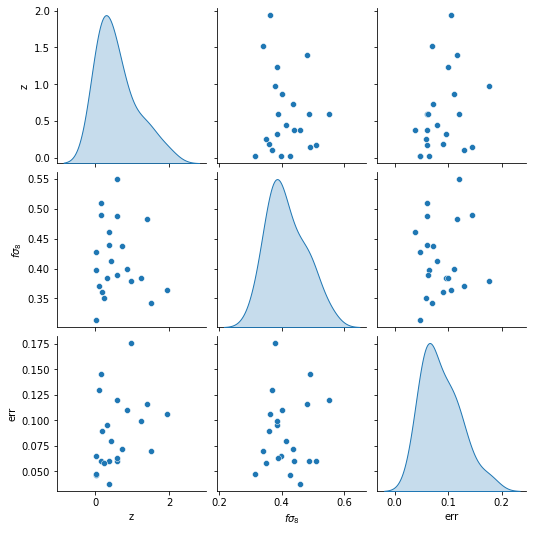

In [140]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [141]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [142]:
z = data[:,0]
y = data[:,1:]
# print(randomize)
np.max(z)

1.944

In [143]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [144]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [145]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [146]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [147]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 100

In [148]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0421 - val_loss: 0.0169
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0206 - val_loss: 0.0215
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0048
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 11/

17/17 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 84/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 85/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 86/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 87/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 88/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 89/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 90/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 91/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 92/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 93/100


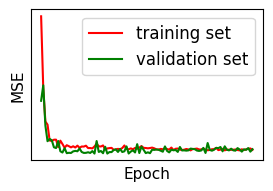

In [149]:
# plt.plot(model_train.history['loss'], color='r', )
# plt.plot(model_train.history['val_loss'], color='g')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# # plt.xscale('log')
# plt.xlim(0)
# plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
plt.savefig('loss_fs8_corr.png')


In [159]:
# neural_model.save("FFNN_fs8_correction.h5")

In [151]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e
### 100
# 0.001952524995431304 0.0008627769420854747
# 0.001952524995431304 0.002966993721202016
dif_loss = model_train.history['val_loss'][-1] - model_train.history['val_loss'][-2]
val_loss = model_train.history['val_loss'][-1]
dif_loss, val_loss

0.0020862251985818148 0.0011292494600638747
0.002241606591269374 0.0024330609012395144


(0.0007245913147926331, 0.0024330609012395144)

In [152]:
pred = neural_model.predict(z_test)
pred

array([[0.4677086 , 0.06518513],
       [0.4773769 , 0.09168287],
       [0.4584265 , 0.0995269 ],
       [0.4422282 , 0.10473281],
       [0.40943164, 0.11419518]], dtype=float32)

In [153]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [154]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


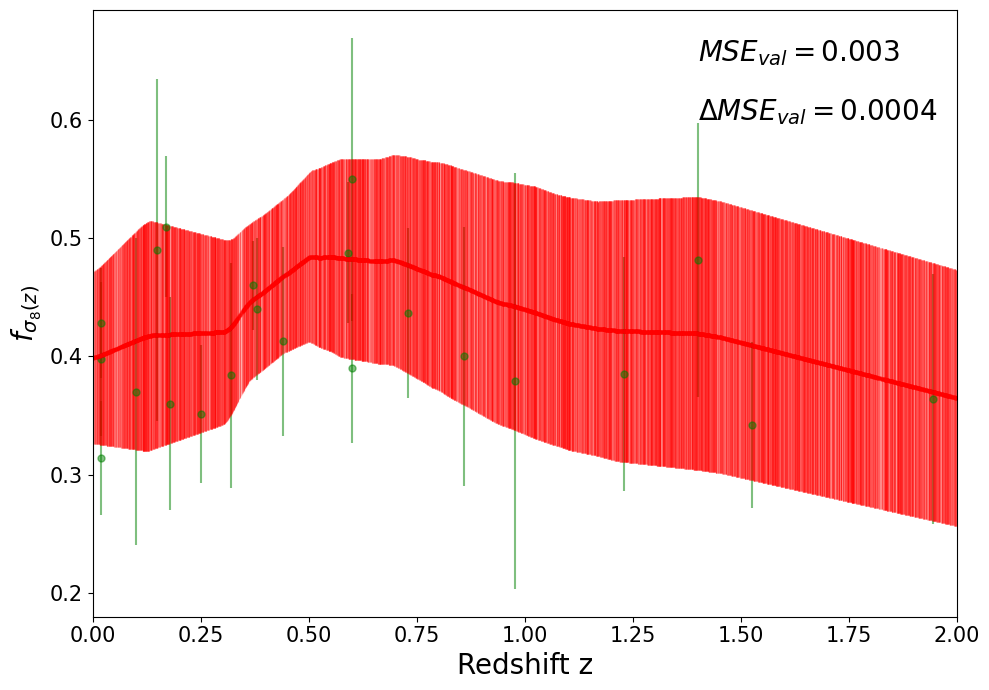

In [155]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.1, c='r',)
plt.ylabel("$f_{\sigma_8(z)}$", fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.text( 1.4, 0.65, "$MSE_{val} = 0.003$", fontsize=20 )
plt.text( 1.4, 0.6, "$\Delta MSE_{val} = 0.0004$", fontsize=20 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.legend(loc='upper right')
# plt.legend()
# plt.savefig("synthetic_fs8_1000.png")

In [156]:
from functools import partial
# Cosmological constants
Om = 0.342
# variance network
s8 = 0.8
h = 1
# def Ezlcdm(a):
#     return np.sqrt(Om*(1/a)**3 + 1 - Om)

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
# #     return Om*(1/a)**3 + 1 - Om
#     w0 = -1.0
#     wa = 0.0
#     rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
#     return (Om/a**3+(1.0-Om)*rhow)

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return h**2*(Om/a**3+(1.0-Om)*rhow)

  
# def growth_lcdm(z):
#     # Equation 7.77 from Doddie
#     af = 1./(1. + z)
#     r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
#     gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
#     gr *= 5/2.*Om
#     return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_owacdm(af, w0, wa))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# # returns the growth factor as a function of redshift
# def GrowthIntegrand_a_lcdm(a):
#     rhsquareda = RHSquared_a_lcdm(a) 
#     return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)

# def fs8lcdm(z):
#     return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)

In [157]:
z = np.linspace(0.0, 2, 1000)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []
fowacdm4 = []

# flcdm = []
for zz in z:
#     flcdm.append(fs8lcdm(zz))
    flcdm.append(fs8owacdm(zz, w0=-1, wa=0.0))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-0.8,wa=-0.13))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)

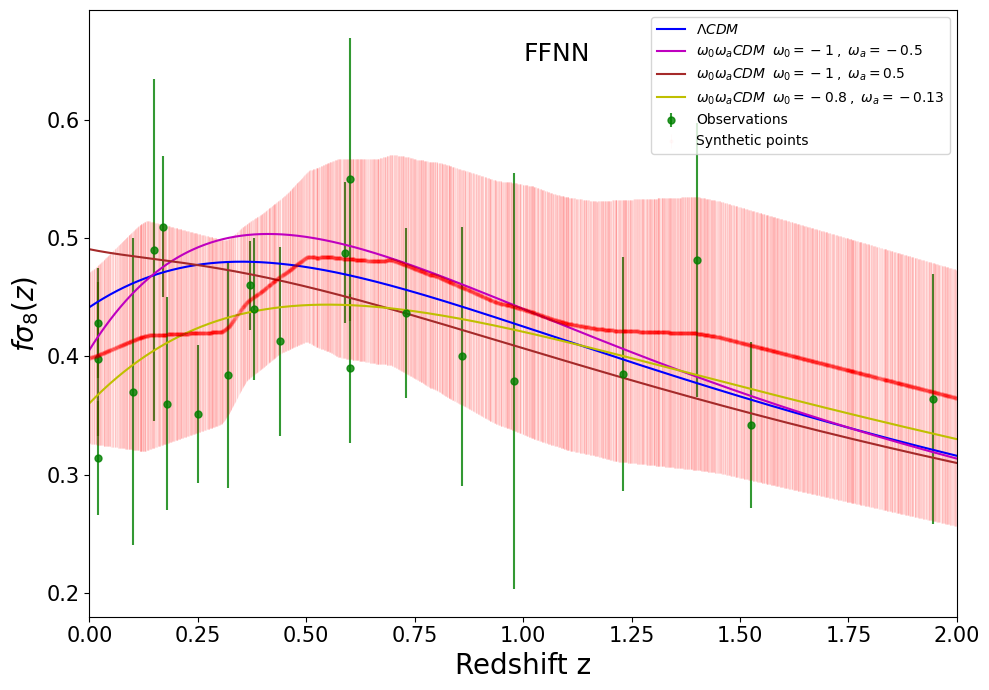

In [158]:
plt.figure(figsize=(10, 7), dpi=100)

z = np.linspace(0, 2, 1000)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.02, c='r',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_0 = -1 \;,\; \omega_a=-0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_0 = -1 \;,\; \omega_a=0.5$', c='brown')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_0 =-0.8 \;,\; \omega_a=-0.13$', c='y')
plt.text(1,0.65,'FFNN', fontsize=18)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f\sigma_8(z)$", fontsize=20)
plt.tight_layout()
plt.legend()

plt.savefig("Syntheticfs8_correction.png",dpi=100)

In [23]:
# pred_random.shape, r.shape

In [24]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [25]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [26]:
mookHz

array([[1.44064325, 0.43492031, 0.11330655],
       [0.93255669, 0.46071273, 0.11742255],
       [1.00438748, 0.44981283, 0.11457857],
       [0.22436751, 0.40370071, 0.08394254],
       [0.20318425, 0.40318435, 0.08468799],
       [1.77706086, 0.3768909 , 0.11387338],
       [1.56462178, 0.41524357, 0.11421838],
       [0.30838882, 0.40444362, 0.07626981],
       [1.3009323 , 0.42862993, 0.10773812],
       [1.33420929, 0.43147957, 0.10802492],
       [1.08447387, 0.43598592, 0.11044834],
       [1.41470992, 0.43616509, 0.11275695],
       [1.07058274, 0.43879503, 0.11106619],
       [1.96230102, 0.34973574, 0.11389498],
       [0.92432318, 0.4619844 , 0.11772532],
       [0.10614695, 0.39395285, 0.07059797],
       [0.67476377, 0.47617805, 0.09708598],
       [1.06789697, 0.4393456 , 0.11119033],
       [0.55483382, 0.47616041, 0.06976025],
       [0.99210909, 0.45158702, 0.11505409],
       [0.55425882, 0.47613746, 0.0696329 ],
       [0.02259198, 0.38631153, 0.05786731],
       [1.

In [27]:
predy_reduced[:,1]

array([0.11330655, 0.11742255, 0.11457857, 0.08394254, 0.08468799,
       0.11387338, 0.11421838, 0.07626981, 0.10773812, 0.10802492,
       0.11044834, 0.11275695, 0.11106619, 0.11389498, 0.11772532,
       0.07059797, 0.09708598, 0.11119033, 0.06976025, 0.11505409,
       0.0696329 , 0.05786731, 0.10692944, 0.116119  , 0.05692513,
       0.05694175, 0.10704552, 0.11804787, 0.11413404, 0.10773812,
       0.07944784, 0.0590435 , 0.05982763, 0.05764552, 0.10371771,
       0.05735384, 0.11402626, 0.113571  , 0.10767403, 0.10763188,
       0.11153931, 0.11407407, 0.11423885, 0.07437293, 0.07944784,
       0.0657661 , 0.10956251, 0.11412504, 0.10659463, 0.10755152],
      dtype=float32)

In [28]:
error  = predy_reduced[:,1]**2
error

array([0.01283837, 0.01378806, 0.01312825, 0.00704635, 0.00717206,
       0.01296715, 0.01304584, 0.00581708, 0.0116075 , 0.01166938,
       0.01219884, 0.01271413, 0.0123357 , 0.01297207, 0.01385925,
       0.00498407, 0.00942569, 0.01236329, 0.00486649, 0.01323744,
       0.00484874, 0.00334863, 0.01143391, 0.01348362, 0.00324047,
       0.00324236, 0.01145874, 0.0139353 , 0.01302658, 0.0116075 ,
       0.00631196, 0.00348613, 0.00357934, 0.00332301, 0.01075736,
       0.00328946, 0.01300199, 0.01289837, 0.0115937 , 0.01158462,
       0.01244102, 0.01301289, 0.01305052, 0.00553133, 0.00631196,
       0.00432518, 0.01200394, 0.01302452, 0.01136241, 0.01156733],
      dtype=float32)

In [29]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

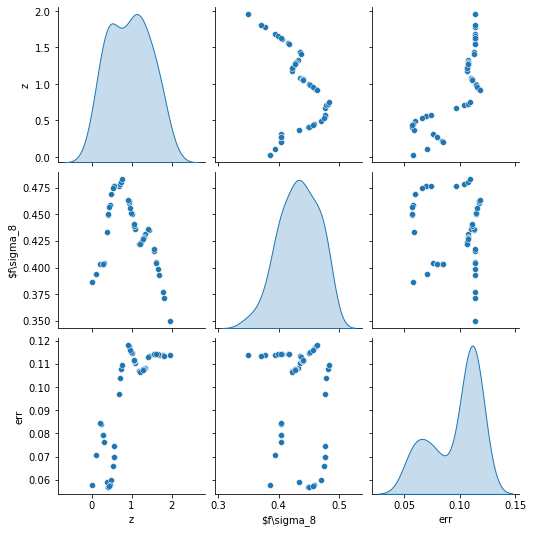

In [30]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [31]:
from astroNN.nn.layers import MCDropout

In [32]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((800,), (22, 1), (200,), (0, 1))

In [33]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model2 = model_regression_dropout(num_hidden=[100, 50, 50])
model2.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model2.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

/home/isidro/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/2000
5/5 [==============================] - 0s 20ms/step - loss: 0.0976 - val_loss: 0.0989
Epoch 2/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.1011 - val_loss: 0.1002
Epoch 3/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0999 - val_loss: 0.1030
Epoch 4/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0889 - val_loss: 0.0791
Epoch 5/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0990 - val_loss: 0.0845
Epoch 6/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0859 - val_loss: 0.0812
Epoch 7/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0881
Epoch 8/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0816 - val_loss: 0.0806
Epoch 9/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0767 - val_loss: 0.0876
Epoch 10/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0762 - val_loss: 0.0751
Epoch 11/2000
5/5 

Epoch 84/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0154
Epoch 85/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0145
Epoch 86/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0166 - val_loss: 0.0142
Epoch 87/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0182 - val_loss: 0.0098
Epoch 88/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 89/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0167 - val_loss: 0.0132
Epoch 90/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 91/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0158 - val_loss: 0.0209
Epoch 92/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0130
Epoch 93/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0142
Epoch 94/2

5/5 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0063
Epoch 167/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 168/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 169/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 170/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0064
Epoch 171/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.0078
Epoch 172/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 173/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 174/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 175/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 176/2000


5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 249/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 250/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 251/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 252/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0015
Epoch 253/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 254/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0028
Epoch 255/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 256/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0073
Epoch 257/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 258/2000


5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 331/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 332/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 333/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 334/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0072
Epoch 335/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 336/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 337/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 338/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 339/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 340/2000


5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 413/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0037
Epoch 414/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 415/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 416/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 417/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 418/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 419/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 420/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 421/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 422/2000


Epoch 494/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 495/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 496/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 497/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 498/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 499/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 500/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 501/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 502/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 503/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0024


Epoch 657/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0065
Epoch 658/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 659/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 660/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 661/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 662/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 663/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 664/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 665/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 666/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0029


Epoch 739/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 740/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 741/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 742/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 743/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 744/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 745/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 746/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 747/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 748/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0013


Epoch 821/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 822/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 823/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 824/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 825/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 826/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 827/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 828/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 829/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 830/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0032


Epoch 903/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 904/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 905/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 906/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 907/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 908/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 909/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 910/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 911/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 912/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0032


Epoch 985/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 986/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 987/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 988/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 989/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 990/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 991/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 992/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 993/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 994/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0019


5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 1148/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 1149/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 1150/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 1151/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 1152/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 1153/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 1154/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 1155/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 1156/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 1310/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 1311/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 1312/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 1313/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 1314/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 1315/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 1316/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1317/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 1318/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 1471/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 1472/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 1473/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 1474/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 1475/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 1476/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 1477/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 1478/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 1479/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 1552/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 1553/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 1554/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 1555/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1556/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 1557/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 1558/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 1559/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 1560/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1714/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 1715/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 1716/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 1717/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 1718/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 1719/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 1720/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 1721/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 1722/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 1876/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 1877/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 1878/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 1879/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 1880/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1881/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 1882/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 1883/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 1884/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 

In [34]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [35]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.030532509818949154, 0.015855798103976523)

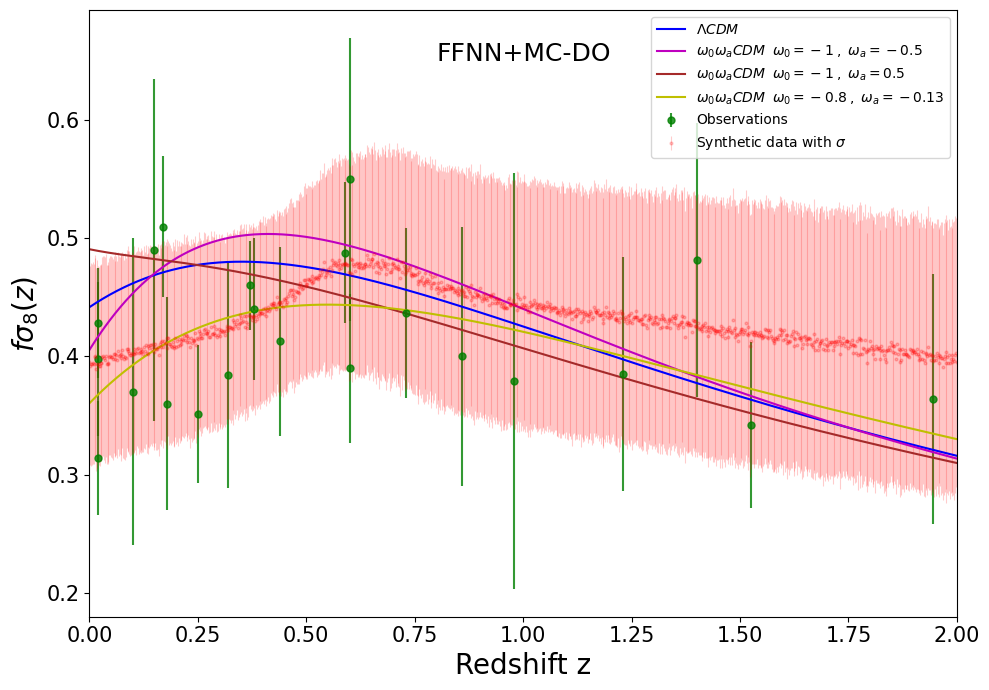

In [48]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.2, c='r',
             label='Synthetic data with $\sigma$')




plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_0 = -1 \;,\; \omega_a=-0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_0 = -1 \;,\; \omega_a=0.5$', c='brown')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_0 =-0.8 \;,\; \omega_a=-0.13$', c='y')
plt.text(0.8,0.65,'FFNN+MC-DO', fontsize=18)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f\sigma_8(z)$", fontsize=20)
plt.tight_layout()
plt.legend()


plt.savefig('fs8_dropoutb_correction.png', dpi=100)

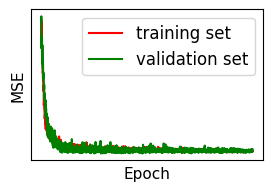

In [37]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
plt.savefig('loss_fs8_DO_corr.png')

In [1]:
# tf.keras.models.save_model(model2, '../models/FFNN_MC_DO_fs8_correction.h5' )

In [39]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [40]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

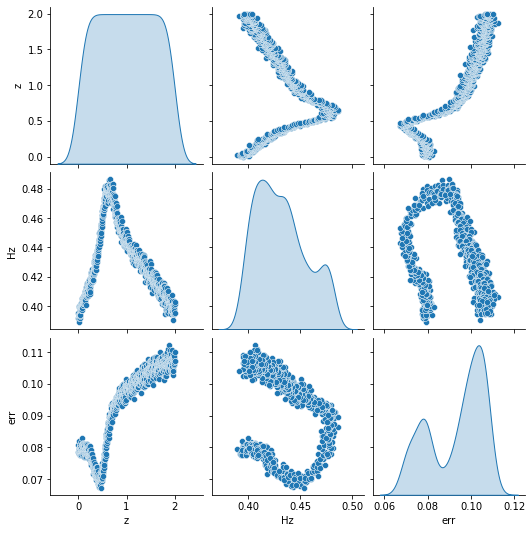

In [41]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")